# Tutorial

We will do the assembly and merging using the example data in the tests/data directory in the following order:

1. Preparing sample info spreadsheet
2. Preparing inputs
3. Assembling individual samples
4. Evalulation of individual assemblies
5. Preparing for merge
6. Merging
7. Evaluation of the merged assembly
8. Annotating merged assembly

The example data is the chromosome 1 portion of the RNASeq data from the neurons in superior central nucleus raphe, medial part (CSm) and dosal nucleus raphe (DR) in Fev-Cre mouse line which labels serotoninergic neurons.  (Fev-Cre is also called ePet-Cre.) 


First we will change the logging level for jupyter notebook and enable inline matplotlib figure:

In [1]:
# This is to change logging level of jupyter notebook
try:
    from importlib import reload # for python 3
except:
    pass
import logging
reload(logging)
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')

# This is to show matplotlib output in the notebook
%matplotlib inline
import matplotlib.pylab as P

## Sample Info

For this tutorial, we will use the Excel file **sampleinfo.xlsx** in the tests/data directory. Following fields are required:

- **name**: unique sample name
- **mapbed**: name (or path) of BED file containing mapped reads
- **sjtab**: name (or path) of STAR SJ.out.tab output file


In [2]:
import pandas as PD

si = PD.read_excel('../tests/data/sampleinfo.xlsx')
print(si[['name','mapbed','sjtab']])

                    name                             mapbed  \
0   Fev_DR_m70_1623.chr1   Fev_DR_m70_1623_star.chr1.bed.gz   
1  Fev_CSm_m70_1624.chr1  Fev_CSm_m70_1624_star.chr1.bed.gz   
2   Fev_DR_m71_1625.chr1   Fev_DR_m71_1625_star.chr1.bed.gz   
3  Fev_CSm_m71_1626.chr1  Fev_CSm_m71_1626_star.chr1.bed.gz   

                              sjtab  
0   Fev_DR_m70_1623.chr1.SJ.out.tab  
1  Fev_CSm_m70_1624.chr1.SJ.out.tab  
2   Fev_DR_m71_1625.chr1.SJ.out.tab  
3  Fev_CSm_m71_1626.chr1.SJ.out.tab  


The read mapping output from STAR is a BAM file. We convert the BAM file to BED file. You can do this using **bedtools bamtobed** command, or using the wrapper [jgem.bedtools.bam2bed](modules.html#jgem.bedtools.bam2bed):

```python
from jgem import bedtools as BT
BT.bam2bed(bam_path,bed_path)
```

STAR also creates a file named SJ.out.tab which contains junction information. 

First, we'll create columns containing actual paths of these files in the sampleinfo dataframe.

In [3]:
import os

BASEDIR = '../tests/data'
si['bed_path'] = [os.path.join(BASEDIR, "BED", x) for x in si['mapbed']]
si['sjtab_path'] =  [os.path.join(BASEDIR, "SJ", x) for x in si['sjtab']]

print(si[['name','bed_path','sjtab_path']])

                    name                                           bed_path  \
0   Fev_DR_m70_1623.chr1  ../tests/data/BED/Fev_DR_m70_1623_star.chr1.be...   
1  Fev_CSm_m70_1624.chr1  ../tests/data/BED/Fev_CSm_m70_1624_star.chr1.b...   
2   Fev_DR_m71_1625.chr1  ../tests/data/BED/Fev_DR_m71_1625_star.chr1.be...   
3  Fev_CSm_m71_1626.chr1  ../tests/data/BED/Fev_CSm_m71_1626_star.chr1.b...   

                                          sjtab_path  
0   ../tests/data/SJ/Fev_DR_m70_1623.chr1.SJ.out.tab  
1  ../tests/data/SJ/Fev_CSm_m70_1624.chr1.SJ.out.tab  
2   ../tests/data/SJ/Fev_DR_m71_1625.chr1.SJ.out.tab  
3  ../tests/data/SJ/Fev_CSm_m71_1626.chr1.SJ.out.tab  


## Preparing Inputs to the assembler

We need a BIGWIG file containing normalized coverages and an appropriately formatted BED file containing junction information for the inputs to the assembler.

To normalize coverage, we use average coverage which is the number of the total mapped base pairs divided by the number of covered base pairs. This can be calculated using  [jgem.bedtools.get_total_bp_bedfile](modules.html#jgem.bedtools.get_total_bp_bedfile):

In [4]:
# calculate total bp and covered bp, takes ~1min
from jgem import bedtools as BT
tot_cov = [BT.get_total_bp_bedfile(x) for x in si['bed_path']]
si['totbp'] = [x[0] for x in tot_cov]
si['covbp'] = [x[1] for x in tot_cov]
si['acov'] = si['totbp']/si['covbp']
print(si[['name','totbp','covbp','acov']])

                    name      totbp     covbp       acov
0   Fev_DR_m70_1623.chr1  145699916   9142973  15.935726
1  Fev_CSm_m70_1624.chr1  158992441  11276760  14.099124
2   Fev_DR_m71_1625.chr1  161359243  13946848  11.569585
3  Fev_CSm_m71_1626.chr1  161885717  11661445  13.882132


Now normalized BIGWIG coverage files can be generated using [jgem.bedtools.bed2bw](modules.html#jgem.bedtools.bed2bw) function:

In [5]:
# first prepare destination
si['bw_path'] = [os.path.join(BASEDIR, "bigwig/{0}.bw".format(x)) for x in si['name']]
# then make coverages BIGWIG from BED (~ 2 min)
from jgem import utils as UT
chromsizes = UT.chromsizes('mm10') # a file containing chromosome names and sizes
for bedfile, bwfile, acov in si[['bed_path','bw_path','acov']].values:
    scale = 1./acov
    BT.bed2bw(bedfile, chromsizes, bwfile, scale)

In [6]:
ls ../tests/data/bigwig/*chr1.bw

../tests/data/bigwig/Fev_CSm_m70_1624.chr1.bw
../tests/data/bigwig/Fev_CSm_m71_1626.chr1.bw
../tests/data/bigwig/Fev_DR_m70_1623.chr1.bw
../tests/data/bigwig/Fev_DR_m71_1625.chr1.bw


To generate junction files from SJ.out.tab, use function [jgem.gtfgffbed.sjtab2sjbed](modules.html#jgem.gtfgffbed.sjtab2sjbed):

In [7]:
# sjbed destination
si['sjbed_path'] = [os.path.join(BASEDIR, "SJ/{0}.sj.bed.gz".format(x)) for x in si['name']]
# SJ.out.tab => sjbed
from jgem import gtfgffbed as GGB
for sjtab, sjbed, acov in si[['sjtab_path','sjbed_path','acov']].values:
    scale = 1./acov
    GGB.sjtab2sjbed(sjtab,sjbed,scale)

In [8]:
ls ../tests/data/SJ/*chr1.sj.bed.gz

../tests/data/SJ/Fev_CSm_m70_1624.chr1.sj.bed.gz
../tests/data/SJ/Fev_CSm_m71_1626.chr1.sj.bed.gz
../tests/data/SJ/Fev_DR_m70_1623.chr1.sj.bed.gz
../tests/data/SJ/Fev_DR_m71_1625.chr1.sj.bed.gz


Let's check the content of generated SJBED file.

In [9]:
sj = GGB.read_sj(sjbed)
print(sj.head())

    chr       st       ed                 name      ucnt strand      mcnt
0  chr1  3121707  3142317   CT/AC-k0-u4-m0-o46  0.288140      -  0.000000
1  chr1  3207318  3213438  CT/AC-k0-u10-m0-o47  0.720350      -  0.000000
2  chr1  3271573  3302745   GT/AG-k0-u0-m1-o37  0.000000      +  0.072035
3  chr1  3421902  3670551  CT/AC-k1-u20-m0-o43  1.440701      -  0.000000
4  chr1  3660890  3670551   CT/AC-k0-u2-m0-o41  0.144070      -  0.000000


### SJBED file format

As shown above, the tab separated junction file should contain:

- **chr**:  chromosome name
- **st**: start position
- **ed**: end position
- **name**: junction name
- **ucnt**: unique reads (normalized to average coverage)
- **strand**: strand of junction
- **mcnt**: non-unique (multimapping) reads (normalized)


## Assembling individual samples

Use [FileNames class](modules.html#jgem.filenames.FileNames) to specify inputs (bigwig file and sjbed file) and output directory, then use [Assembler class](modules.html#jgem.assembler.Assembler) to do the assembly.

INFO:Executing SELECTSJ ====================
INFO: #sj:7660=>7649
INFO: time: 0.572s
INFO:Executing REMOVEJIE ====================
INFO: #sj:7649=>7639, jie 10
INFO: time: 1.903s
INFO:Executing SJ2EX ====================
INFO:#sj:7639=>7639 after ureadth, mreadth
INFO: #ex:8126, #sj:7639
INFO: time: 0.110s
INFO:Executing MERGEEXONS ====================
INFO: #ex:8204
INFO: time: 0.203s
INFO:Executing FINDEDGES ====================
INFO: time: 1.754s
INFO:Executing FIXSTRAND ====================
INFO: time: 0.429s
INFO:Executing EDGEFIXER ====================
INFO: time: 15.209s
INFO:Executing FINDIRETS ====================
INFO:#irets candidates:170
INFO:168 irets found
INFO: time: 6.295s
INFO:Executing FINDSECOVTH ====================
INFO: SECOVTH=0.7479972670226993
INFO: time: 6.432s
INFO:Executing FINDSE ====================
INFO:#candidate SE:10810
INFO:  processing 10810 SE candidates
INFO:#candidate SE after _fix_se_ext:10712
INFO:write exons ...=> assemble.exons0.txt.gz
INFO: t

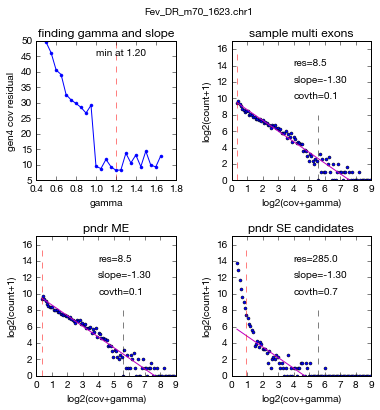

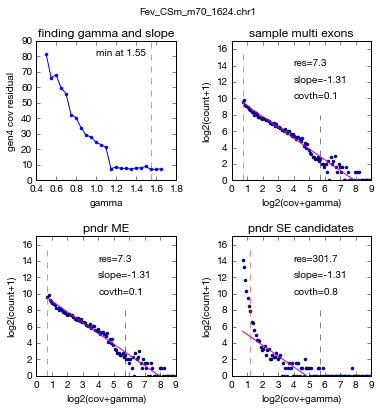

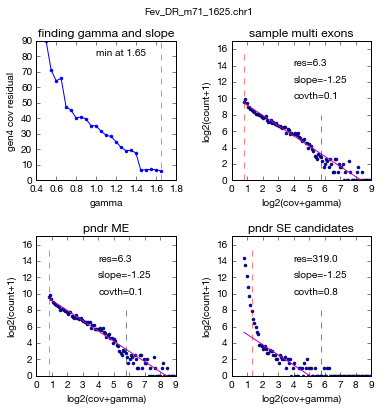

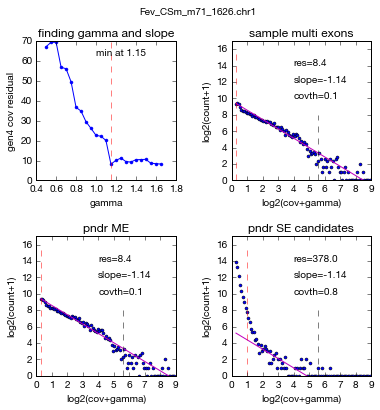

In [10]:
# assemble 4 samples takes about ~10 min 
from jgem import filenames as FN
from jgem import assembler as AS
for name,bwfile,sjfile in si[['name','bw_path','sjbed_path']].values:
    fn = FN.FileNames(name, bwfile, sjfile, outdir='../tests/out')
    p = AS.Assembler(fn,saveintermediates=False)
    p.assemble()

Generated figures visualize the process of finding coverage threshold for single exons. (See ...)

In the output directory, several files are generated:

In [11]:
ls ../tests/out/Fev_DR_m70_1623*

../tests/out/Fev_DR_m70_1623.chr1.assemble.params.txt.gz
../tests/out/Fev_DR_m70_1623.chr1.assemble.stats.txt
../tests/out/Fev_DR_m70_1623.chr1.ci.txt.gz
../tests/out/Fev_DR_m70_1623.chr1.ex.bed.gz
../tests/out/Fev_DR_m70_1623.chr1.ex.txt.gz
../tests/out/Fev_DR_m70_1623.chr1.findsecovth.params.txt
../tests/out/Fev_DR_m70_1623.chr1.findsecovth.pdf
../tests/out/Fev_DR_m70_1623.chr1.genes.bed.gz
../tests/out/Fev_DR_m70_1623.chr1.selectsj.sj2.txt.gz
../tests/out/Fev_DR_m70_1623.chr1.sj.bed.gz
../tests/out/Fev_DR_m70_1623.chr1.sj.txt.gz


Main outputs are files with .ex.txt.gz, .sj.txt.gz suffixes. These contain exons and junctions in tab separated format. BED files are also generated for viewing elements (genes,exons,junctions) with browsers like IGV (https://www.broadinstitute.org/igv/). The screenshot below is a segment of chromosome 1 showing genes.bed files from the 4 samples. 

![](_static/GD1YM1XSXBVB8NOM2KDWF3FB0H5DE3OW.png)

Other files (assemble.params.txt.gz, assemble.stats.txt.gz, findsecovth.params.txt.gz, findsecovth.pdf) contain parameters and statistics of the assembly.

## Evaluation of individual assemblies

We will evaluate the assemblies against [Gencode.VM4 annotation](http://www.gencodegenes.org/mouse_releases/4.html). For this, we use  [EvalNames class](modules.html#jgem.evalutate.EvalNames) and [EvalMatch class](modules.html#jgem.evalutate.EvalMatch). 

In [12]:
# Evaluate against Gencode.VM4 (~1 min)
from jgem import evaluate as EV
ens = {} # keep EvalNames objects
ems = {} # keep EvalMatch object
# Gencode.VM4
en_gen4 = EV.EvalNames('../tests/data/assemblies/gencode.vM4.chr1', code='gen4', outdir='../tests/out/')
# assign sample code
si['scode'] = [x.split('_')[-1].split('.')[0] for x in si['name']]
# For each sample
for scode, name, bwfile, sjfile in si[['scode','name','bw_path','sjbed_path']].values:
    print('process {0}...'.format(name))
    sjexbase = '../tests/out/'+name # prefix to .ex.txt.gz and .sj.txt.gz files
    assemblycode = 'a'+str(scode) # assembly identifier
    datacode = 'd'+str(scode) # data identifier
    ens[name] = EV.EvalNames(sjexbase,  code=assemblycode, outdir='../tests/out/') 
    ems[name] = EV.EvalMatch(en_gen4, ens[name], bwfile, sjfile, datacode=datacode, binsize=100) 
    ems[name].calculate()

process Fev_DR_m70_1623.chr1...


INFO:[i] detected1:7766,	matched:5583,	(detected2:5820),	ratio:0.72,	(ratio2:0.96)
INFO:[5] detected1:2341,	matched:1116,	(detected2:1536),	ratio:0.48,	(ratio2:0.73)
INFO:[3] detected1:2607,	matched:1139,	(detected2:1802),	ratio:0.44,	(ratio2:0.63)
INFO:[s] detected1:894,	matched:95,	(detected2:385),	ratio:0.11,	(ratio2:0.25)
INFO:[j] detected1:6892,	matched:6665,	(detected2:7251),	ratio:0.97,	(ratio2:0.92)
INFO:[5b] detected1:2341,	matched:1573,	(detected2:9543),	ratio:0.67,	(ratio2:0.16)
INFO:[3b] detected1:2607,	matched:1706,	(detected2:9543),	ratio:0.65,	(ratio2:0.18)
INFO:[sb] detected1:894,	matched:262,	(detected2:9543),	ratio:0.29,	(ratio2:0.03)


process Fev_CSm_m70_1624.chr1...


INFO:[i] detected1:7990,	matched:5858,	(detected2:6163),	ratio:0.73,	(ratio2:0.95)
INFO:[5] detected1:2418,	matched:1163,	(detected2:1736),	ratio:0.48,	(ratio2:0.67)
INFO:[3] detected1:2734,	matched:1229,	(detected2:2075),	ratio:0.45,	(ratio2:0.59)
INFO:[s] detected1:961,	matched:91,	(detected2:299),	ratio:0.09,	(ratio2:0.30)
INFO:[j] detected1:7153,	matched:6948,	(detected2:7722),	ratio:0.97,	(ratio2:0.90)
INFO:[5b] detected1:2418,	matched:1634,	(detected2:10273),	ratio:0.68,	(ratio2:0.16)
INFO:[3b] detected1:2734,	matched:1832,	(detected2:10273),	ratio:0.67,	(ratio2:0.18)
INFO:[sb] detected1:961,	matched:269,	(detected2:10273),	ratio:0.28,	(ratio2:0.03)


process Fev_DR_m71_1625.chr1...


INFO:[i] detected1:8259,	matched:5950,	(detected2:6327),	ratio:0.72,	(ratio2:0.94)
INFO:[5] detected1:2526,	matched:1185,	(detected2:2032),	ratio:0.47,	(ratio2:0.58)
INFO:[3] detected1:2887,	matched:1318,	(detected2:2544),	ratio:0.46,	(ratio2:0.52)
INFO:[s] detected1:1004,	matched:90,	(detected2:334),	ratio:0.09,	(ratio2:0.27)
INFO:[j] detected1:7336,	matched:7107,	(detected2:7974),	ratio:0.97,	(ratio2:0.89)
INFO:[5b] detected1:2526,	matched:1668,	(detected2:11237),	ratio:0.66,	(ratio2:0.15)
INFO:[3b] detected1:2887,	matched:1910,	(detected2:11237),	ratio:0.66,	(ratio2:0.17)
INFO:[sb] detected1:1004,	matched:273,	(detected2:11237),	ratio:0.27,	(ratio2:0.02)


process Fev_CSm_m71_1626.chr1...


INFO:[i] detected1:7985,	matched:5725,	(detected2:6018),	ratio:0.72,	(ratio2:0.95)
INFO:[5] detected1:2462,	matched:1210,	(detected2:1837),	ratio:0.49,	(ratio2:0.66)
INFO:[3] detected1:2750,	matched:1232,	(detected2:2132),	ratio:0.45,	(ratio2:0.58)
INFO:[s] detected1:969,	matched:88,	(detected2:401),	ratio:0.09,	(ratio2:0.22)
INFO:[j] detected1:7085,	matched:6840,	(detected2:7559),	ratio:0.97,	(ratio2:0.90)
INFO:[5b] detected1:2462,	matched:1692,	(detected2:10388),	ratio:0.69,	(ratio2:0.16)
INFO:[3b] detected1:2750,	matched:1823,	(detected2:10388),	ratio:0.66,	(ratio2:0.18)
INFO:[sb] detected1:969,	matched:256,	(detected2:10388),	ratio:0.26,	(ratio2:0.02)


INFO outputs are as follows: 

- detected1: counts of gencode exons/junctions with positive coverage
- matched: number of matched exons/junctions 
- detected2: counts of elements in the assembly 
- ratio: matched/detected1
- ratio2: matched/detected2 

These are assesed within different exon classes: 

- **i**: internal exon (exons bounded by splice junctions)
- **5**: 5'exons
- **3**: 3'exons
- **s**: single exons
- **j**: junctions
    
Classes with **b**, (**5b**,**3b**,**sb**) allow matching to different classes of exons. 

Matching exons with junction boundary requires the boundaries to match. That is, to match internal exons, they have to be exactly the same (including strand). To match 5'exons, donor site has to the same but the other side does not have to be. To match single exon, they just need to have some overlap. 

So, we have quite good detection of junctions. About 70% of internal exons are detected. 5',3' exons are worse (< 50%) but if allowed to match to other class of exons, then detection rates get close to the internal exons. Single exon detection rates are bad and about 10%.


We can visualize the detection percentages as follows.

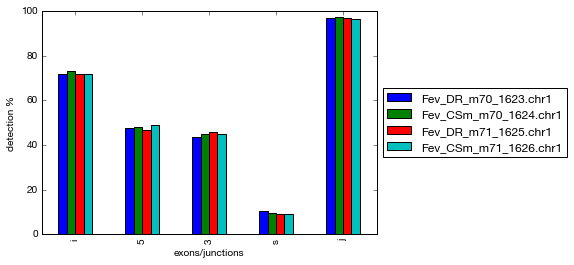

In [13]:
# EvalMatch.get_detection_percentages returns a dataframe containing detection percentages 
dp = PD.DataFrame({n:ems[n].get_detection_percentages().stack() for n in ems})
tgt = ['i','5','3','s','j']
dp1 = dp.ix[[(x,'%detected 1') for x in tgt]][si['name'].values]
dp1.index = tgt
ax = dp1.plot(kind='bar', legend=False, figsize=(6,4))
ax.set_ylabel('detection %')
ax.set_xlabel('exons/junctions')
ax.legend(loc='center left', bbox_to_anchor=(1,0.5))

We can also plot the detection sensitivity against coverages. We expect the detection rate is better at the bigger coverage.

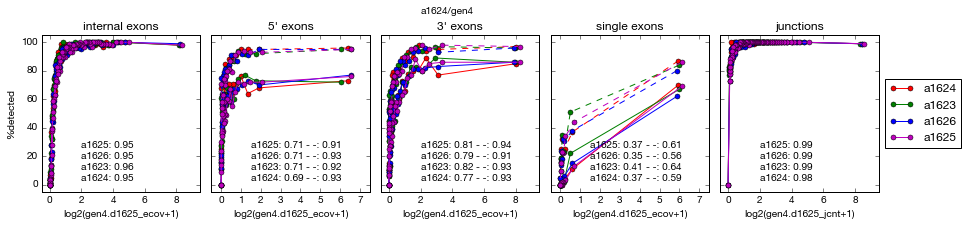

In [14]:
colors = ['ro-','go-','bo-','mo-']
for i,name in enumerate(ems):
    em = ems[name]
    if i==0:
        axr = em.plot_sensitivity(color=colors[i])
    else:
        axr = em.plot_sensitivity(color=colors[i], axr=axr, ypos=i)

These plots show percent of detected exons calculated in bins sorted by coverage (binsize 100). Numbers in inset indicate normalized area under the curve (AUC, which ranges from 0 to 1).  Dashed lines in 5',3' and single exon panels correspond to 5b, 3b, sb category. 

How about the precision of the match? We can assess this by length ratio of matched exons:

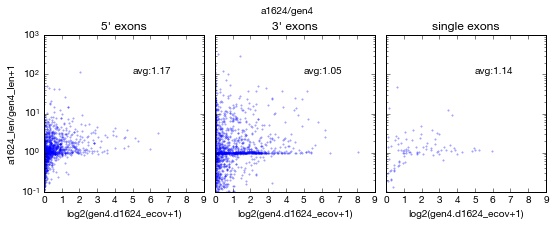

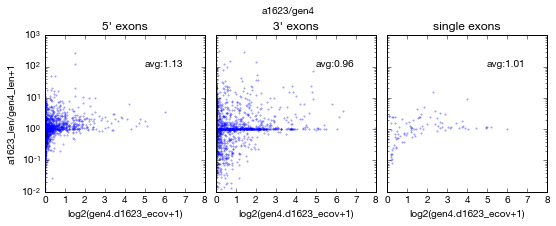

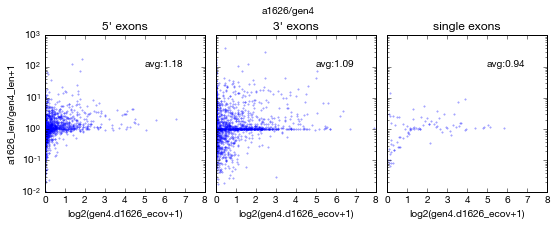

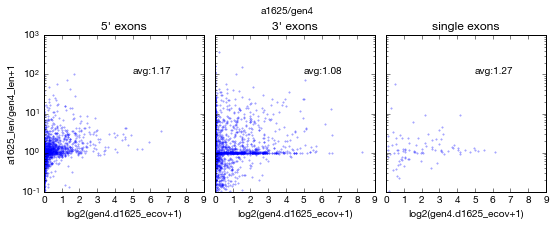

In [15]:
for name in ems:
    ems[name].plot_ratio()

Averages shown inside are geometric averages. Overall length tends to be a bit longer. (Matching of internal exons and junctions always produce ratio of 1, so they are not shown.)

For some genes, we see partial or disconnected reconstruction of the structure. An example is shown below:

![](_static/XLYS4AQF3MKU4PDJ17VOM2LBW63I566O.png)

These incomplete reconstructions are due to missing junctions or insufficient exon coverages.

To evaluate the *completeness* of the reconstruction, we calculate three measures. One is the ratio of gene length. We call this GLC (gene length completenesss). The second measure is the ratio of exon counts (ECC, exon count completeness), and the third is the ratio of junction counts (JCC, junction count completeness).

We can visualize these measures by [plot_completeness](modules.html#jgem.evaluate.EvalMatch.plot_completeness) method.

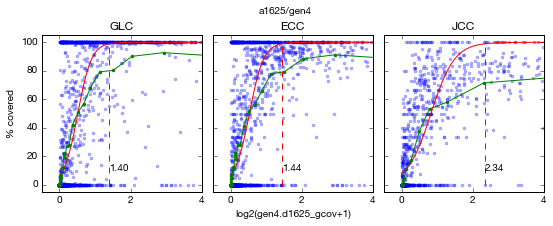

In [16]:
axr = ems[name].plot_completeness(pw='fdat', ca='g.-', cf='r-',  cd='b.', xlim=[0,4])

Blue dots are genes, green dots are binned averages, red lines are sigmoid function fit to blue dots and red dashes are 99% position of the sigmoidal fit. 

As expected, genes with low coverages tends to have incomplete reconstructions.

Below, we'll plot binned averages of completeness measures for all 4 samples.

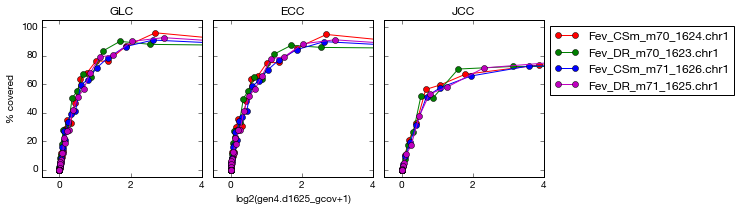

In [17]:
colors = ['ro-','go-','bo-','mo-']
for i,name in enumerate(ems):
    em = ems[name]
    if i==0:
        axr = em.plot_completeness(pw='a', ca=colors[i], xlim=(0,4), label=name, title='')
    else:
        axr = em.plot_completeness(pw='a', ca=colors[i], xlim=(0,4), axr=axr, label=name)
P.legend(bbox_to_anchor=(1,1),loc='upper left')

## Preparing for merge

Since individual cell types express only subsets of the genes, merging assembies is necessary to obtain a more complete picture of the transcriptomes. Moreover, merging should also improve the sensitivity and the completeness of the reconstruction.

For merging, we will repeat the assembly process but uses aggregated junctions and coverage bigwigs generated from all exons from all assemblies. We need to prepare these two kinds of files first. For this, we use [MergeInputs class](modules.html#jgem.merge.MergeInputs). 


In [18]:
from jgem import merge as MG
fni = MG.MergeInputNames(sampleinfo=si, code='FevM', outdir='../tests/out')
mi = MG.MergeInputs(fnobj=fni, genome='mm10', np=3, th_detected=0, th_maxcnt1=0)

We need to assign **sjexpre** column to the sampleinfo:

In [20]:
# prefix to *.ex.txt.gz and *.sj.txt.gz files
si['sjexpre'] = [os.path.join('../tests/out/', x) for x in si['name']]

To create bigwigs:

In [21]:
mi.make_ex_bigwigs()

INFO:../tests/out/FevM.ex.mep.bed.gz:totbp=22889483,covbp=1785031,scale=0.0779847670652937
INFO:../tests/out/FevM.ex.men.bed.gz:totbp=35393861,covbp=2078926,scale=0.05873690920580832
INFO:../tests/out/FevM.ex.se.bed.gz:totbp=3037419,covbp=675251,scale=0.2223107842546583


To make aggreagated junction files:

In [24]:
mi.make_sj_bed()

INFO:selectsj: in 11398
INFO:selectsj: 107 smaller than th_ratio(0.001)
INFO:selectsj: 0 smaller than th_detected(0)
INFO:selectsj: 0 smaller than th_maxcnt1(0)
INFO:selectsj: 4861 larger than th_maxcnt2(1)
INFO:#selected SJ:11291<=11398


To make average bigwig coverage file (average of original individual bigwig coverages, different from bigwigs generated above by make_ex_bigwigs(), which are based on assembled exons):

In [25]:
mi.aggregate_bigwigs() #~ 1 min

Output files are:

In [26]:
ls ../tests/out/FevM*

../tests/out/FevM.allsample.bw        ../tests/out/FevM.ex.se.bw
../tests/out/FevM.allsj.stats.txt.gz  ../tests/out/FevM.sj.n.bed.gz
../tests/out/FevM.allsj.txt.gz        ../tests/out/FevM.sj.p.bed.gz
../tests/out/FevM.ex.men.bw           ../tests/out/FevM.sj0.bed.gz
../tests/out/FevM.ex.mep.bw           ../tests/out/FevM.sj2.txt.gz


Bigwigs generated from assembly exons are separated into multi-exon positive strand, negative strand and single exons:

    .ex.mep.bw
    .ex.men.bw
    .ex.se.bw
    
Similarly junctions are also separated into two strands:

    .sj.p.bed.gz
    .sj.n.bed.gz
    
Averaged bigwig is:

    .allsample.bw: 
    
Other files contain stats.

## Merging

Once we have inputs prepared, we use [MergeAssemble class](modules.html#jgem.merge.MergeAssemble) to do the merging.


In [27]:
fna = MG.MergeAssemblyNames('FevA', outdir='../tests/out')
ma = MG.MergeAssemble(fni,fna,np=3,saveintermediates=False)

In [28]:
ma.assemble()

INFO:Executing CHECKSJSUPPORT ====================
INFO: #sj: 5348=>4828
INFO: time: 0.816s
INFO:Executing REMOVEJIE ====================
INFO: #sj:4828=>4828, jie 0
INFO: time: 0.326s
INFO:Executing SJ2EX ====================
INFO:#sj:4828=>4828 after ureadth, mreadth
INFO: #ex:4883, #sj:4828
INFO: time: 0.082s
INFO:Executing MERGEEXONS ====================
INFO: #ex:5708
INFO: time: 0.165s
INFO:Executing FINDEDGES2 ====================
INFO: time: 14.420s
INFO:Executing FIXSTRAND ====================
INFO: time: 0.223s
INFO:Executing FINDIRETS ====================
INFO:#irets candidates:155
INFO:226 irets found
INFO: time: 2.325s
INFO:Executing FIND53IR ====================
INFO:  calculating SECOV...
INFO:write exons ...=> assemble.exons0.txt.gz
INFO: time: 2.649s
INFO:Executing CALCCOV ====================
INFO: time: 0.765s
INFO:Executing SETINFO ====================
INFO: time: 0.199s
INFO:Executing FINDGENES ====================
INFO:finding genes (connected components)...
INFO:

Output files are:

In [30]:
ls ../tests/out/FevA*

../tests/out/FevA.ci.txt.gz
../tests/out/FevA.ex.bed.gz
../tests/out/FevA.ex.txt.gz
../tests/out/FevA.genes.bed.gz
../tests/out/FevA.genes.txt.gz
../tests/out/FevA.men.assemble.stats.txt
../tests/out/FevA.mep.assemble.stats.txt
../tests/out/FevA.se.bed.gz
../tests/out/FevA.sj.bed.gz
../tests/out/FevA.sj.txt.gz


Looking at .genes.bed file with IGV, we find previously incomplete reconstructions are now merged into one complete structure:

![](_static/HF0TPO3FMEPGDMG1TQW3Y34I8QIUYB42.png)

To evaluate the merging quantitatively, we use EvalMatch class as before:

In [31]:
ems2 = {} # keep EvalMatch object 
en_m = EV.EvalNames('../tests/out/FevA',  code='FevA', outdir='../tests/out/') 
# for each sample data generate EvalMatch between the merged assembly and the gencode4
for scode, name, bwfile, sjfile in si[['scode','name','bw_path','sjbed_path']].values:
    print('process {0}...'.format(name))
    datacode = 'd'+str(scode)
    ems2[name] = EV.EvalMatch(en_gen4, en_m, bwfile, sjfile, datacode=datacode, binsize=100) 
    ems2[name].calculate()

process Fev_DR_m70_1623.chr1...


INFO:[i] detected1:7766,	matched:6347,	(detected2:7026),	ratio:0.82,	(ratio2:0.90)
INFO:[5] detected1:2341,	matched:1250,	(detected2:1506),	ratio:0.53,	(ratio2:0.83)
INFO:[3] detected1:2607,	matched:1293,	(detected2:1804),	ratio:0.50,	(ratio2:0.72)
INFO:[s] detected1:894,	matched:82,	(detected2:164),	ratio:0.09,	(ratio2:0.50)
INFO:[j] detected1:6892,	matched:6790,	(detected2:7373),	ratio:0.99,	(ratio2:0.92)
INFO:[5b] detected1:2341,	matched:1771,	(detected2:10500),	ratio:0.76,	(ratio2:0.17)
INFO:[3b] detected1:2607,	matched:1945,	(detected2:10500),	ratio:0.75,	(ratio2:0.19)
INFO:[sb] detected1:894,	matched:285,	(detected2:10500),	ratio:0.32,	(ratio2:0.03)


process Fev_CSm_m70_1624.chr1...


INFO:[i] detected1:7990,	matched:6447,	(detected2:7111),	ratio:0.81,	(ratio2:0.91)
INFO:[5] detected1:2418,	matched:1242,	(detected2:1541),	ratio:0.51,	(ratio2:0.81)
INFO:[3] detected1:2734,	matched:1325,	(detected2:1877),	ratio:0.48,	(ratio2:0.71)
INFO:[s] detected1:961,	matched:82,	(detected2:166),	ratio:0.09,	(ratio2:0.49)
INFO:[j] detected1:7153,	matched:7043,	(detected2:7806),	ratio:0.98,	(ratio2:0.90)
INFO:[5b] detected1:2418,	matched:1782,	(detected2:10695),	ratio:0.74,	(ratio2:0.17)
INFO:[3b] detected1:2734,	matched:2009,	(detected2:10695),	ratio:0.73,	(ratio2:0.19)
INFO:[sb] detected1:961,	matched:297,	(detected2:10695),	ratio:0.31,	(ratio2:0.03)


process Fev_DR_m71_1625.chr1...


INFO:[i] detected1:8259,	matched:6532,	(detected2:7244),	ratio:0.79,	(ratio2:0.90)
INFO:[5] detected1:2526,	matched:1262,	(detected2:1639),	ratio:0.50,	(ratio2:0.77)
INFO:[3] detected1:2887,	matched:1364,	(detected2:1985),	ratio:0.47,	(ratio2:0.69)
INFO:[s] detected1:1004,	matched:82,	(detected2:168),	ratio:0.08,	(ratio2:0.49)
INFO:[j] detected1:7336,	matched:7193,	(detected2:8045),	ratio:0.98,	(ratio2:0.89)
INFO:[5b] detected1:2526,	matched:1825,	(detected2:11036),	ratio:0.72,	(ratio2:0.17)
INFO:[3b] detected1:2887,	matched:2083,	(detected2:11036),	ratio:0.72,	(ratio2:0.19)
INFO:[sb] detected1:1004,	matched:289,	(detected2:11036),	ratio:0.29,	(ratio2:0.03)


process Fev_CSm_m71_1626.chr1...


INFO:[i] detected1:7985,	matched:6401,	(detected2:7075),	ratio:0.80,	(ratio2:0.90)
INFO:[5] detected1:2462,	matched:1306,	(detected2:1556),	ratio:0.53,	(ratio2:0.84)
INFO:[3] detected1:2750,	matched:1347,	(detected2:1902),	ratio:0.49,	(ratio2:0.71)
INFO:[s] detected1:969,	matched:82,	(detected2:167),	ratio:0.08,	(ratio2:0.49)
INFO:[j] detected1:7085,	matched:6956,	(detected2:7667),	ratio:0.98,	(ratio2:0.91)
INFO:[5b] detected1:2462,	matched:1855,	(detected2:10700),	ratio:0.75,	(ratio2:0.17)
INFO:[3b] detected1:2750,	matched:2036,	(detected2:10700),	ratio:0.74,	(ratio2:0.19)
INFO:[sb] detected1:969,	matched:284,	(detected2:10700),	ratio:0.29,	(ratio2:0.03)


To visualize detection percentage:

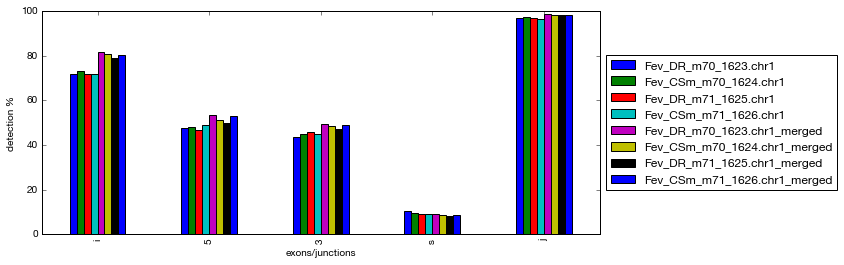

In [32]:
for n in ems2:
    dp[n+'_merged'] = ems2[n].get_detection_percentages().stack()
tgt = ['i','5','3','s','j']
cols = list(si['name'])+[x+'_merged' for x in si['name']]
dp1 = dp.ix[[(x,'%detected 1') for x in tgt]][cols]
dp1.index = tgt
ax = dp1.plot(kind='bar', legend=False, figsize=(10,4))
ax.set_ylabel('detection %')
ax.set_xlabel('exons/junctions')
ax.legend(loc='center left', bbox_to_anchor=(1,0.5))

So we have much better detection of internal exons (~10% improvement) and slight improvements in the detection of 5'exons, 3'exons and junctions. 

We can also see the improvements in the gene structure reconstruction in the changes in GLC,ECC,JCC:

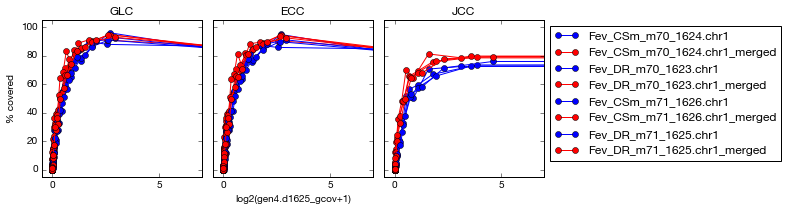

In [33]:
for i,name in enumerate(ems):
    if i==0:
        axr = ems[name].plot_completeness(pw='a', ca='bo-', xlim=(0,4), label=name, title='')
        axr = ems2[name].plot_completeness(pw='a', ca='ro-', label=name+'_merged', axr=axr)
    else:
        axr = ems[name].plot_completeness(pw='a', ca='bo-', label=name, axr=axr)
        axr = ems2[name].plot_completeness(pw='a', ca='ro-', label=name+'_merged', axr=axr)
        
P.legend(bbox_to_anchor=(1,1),loc='upper left')

## Annotating assembly

Once we have an assembly, we want to know which gene model corresponds to which known gene. We do this using [Comparator class](modules.html#jgem.annotate.Comparator). 

In [34]:
from jgem import annotate as AN
g4sjexpre = '../tests/data/assemblies/gencode.vM4.chr1'
mergepre = '../tests/out/FevA'
outdir = '../tests/out'
cref = AN.ComparatorNames(g4sjexpre, 'gen4', outdir)
ctgt = AN.ComparatorNames(mergepre, 'FevA', outdir)
cp = AN.Comparator(cref, ctgt, outdir, 'gene_name')
cp.annotate(overwrite=False)

When overwrite is True, it overwrites the original sj,ex files. If False, it creats files in the output direcotry:

In [35]:
ls ../tests/out/FevA.gen4*

../tests/out/FevA.gen4.ex.txt.gz  ../tests/out/FevA.gen4.sj.txt.gz


Let's check the contents of the exon file:

In [36]:
ex = UT.read_pandas('../tests/out/FevA.gen4.ex.txt.gz')
ex.columns

Index(['chr', 'st', 'ed', 'name', 'sc1', 'strand', '_id', '_gidx', 'gname',
       'cat', 'ptyp', 'cov', 'len', 'a_id', 'd_id', 'a_degree', 'd_degree',
       'a_pos', 'd_pos', 'tlen', 'glen', 'ecov', 'gcov', 'eknown_gen4',
       'etcode_gen4', 'intergenic_gen4', 'ex_as_ovl_gen4', 'gene_as_ovl_gen4',
       'gknown_gen4', 'gtcode_gen4', 'gen4_gidxs', 'gen4_gidx0', 'gen4_syms',
       'gen4_sym0'],
      dtype='object')

In [37]:
acols = ['chr','st','ed','strand','cat','gname','eknown_gen4','etcode_gen4', 
         'intergenic_gen4', 'ex_as_ovl_gen4', 'gene_as_ovl_gen4',
         'gknown_gen4', 'gtcode_gen4','gen4_sym0']
print(ex.head(10)[acols])

    chr       st       ed strand cat   gname eknown_gen4 etcode_gen4  \
0  chr1  3199728  3207317      -   3     NG2           k        k.me   
1  chr1  3213438  3216968      -   i     NG2           k        k.me   
2  chr1  3284679  3285150      .   s  S50000           u        u.se   
3  chr1  3421578  3421901      -   3     NG2           k        k.me   
4  chr1  3421637  3421901      -   3     NG2           k        k.me   
5  chr1  3421701  3421901      -   i     NG2           k        k.me   
6  chr1  3660016  3660889      -   3     NG2           u        u.me   
7  chr1  3670551  3671205      -   5     NG2           k        k.me   
8  chr1  4771187  4772555      .   s  S50001           k        k.se   
9  chr1  4776348  4776801      -   3     NG4           k        k.me   

  intergenic_gen4 ex_as_ovl_gen4 gene_as_ovl_gen4 gknown_gen4 gtcode_gen4  \
0               n              n                n           k        k.me   
1               n              n                n    

Columns are:

    cat: exon category (internal, 5',3',single)
    gname: assembly gene name
    eknown_gen4: exon known against gen4 (k or u)
    etcode_gen4: exon code (k.me: known multi-exon, u.se:unknown single exon, etc.)
    intergenic_gen4: whether the gene is intergenic 
    ex_as_ovl_gen4: exon overlaps with gen4 exon in antisense direction
    gene_as_ovl_gen4: gene overlaps with gen4 gene in antisense direction
    gtcode_gen4: similar to etcode_gen4
    gen4_sym0: Gencode.vM4 gene symbol (0 indicates closest one)
    
    